# Resisting Adversarial Attacks by kWTA Activation
*ICLR Reproducibility Challenge*

**CS4803/7643 Spring 2020 Final Project**

By: Baran Usluel and Ilya Golod

## Our Plan

*Will delete this cell later. For now, linking some resources and our guiding plan (copied from proposal spreadsheet):*

**Paper:** https://arxiv.org/abs/1905.10510

**ICLR Submission Review:** https://openreview.net/forum?id=Skgvy64tvr

**Paper's Github:** https://github.com/a554b554/kWTA-Activation

**Project Summary:**

Implement k-WTA activation function as described in Enhancing Adversarial Defense by k-Winners-Take-All @ ICLR 2020. Reproduce empirical results (test accuracy and adversarial robustness) across the different network architectures, training methods and adversarial attacks shown in the paper. Possibly test with unexplored environments as well.

**Follow-up:**

The k-WTA activation function will be implemented in PyTorch on pretrained models. The architecture models tested will include those in the paper (ResNet, DenseNet and Wide ResNet) and possibly additional relevant models (SqueezeNet, AlexNet, VGG and so on).

The white-box attack model will be examined since this is the main focus of the original paper. Specifically the attacks to be considered are: vanilla gradient ascent (as already implemented in PS2), projected gradient descent, Deepfool, Carlini-Wagner, Momentum Iterative Method, and possibly other state-of-the-art gradient-based adversarial attacks by using the Foolbox library.

Since we are using pretrained models, we will only consider attacks on regularly trained models and not explore adversarial training. Note that the authors claim similar improvements with k-WTA across various training methods.

Finally, we will be using the CIFAR10 dataset for the image classification task.

### Setup

In [56]:
# If using colab:
# Mounts google drive folder so we can save/load files.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [82]:
# Note to team members:
# If you get a 'No such file' error when you run this, go to your Google Drive,
# find the CS4803 Project folder under Shared With Me, right-click and select
# Add Shortcut To Drive. This will make the path accessible.
DATA_DIRECTORY = "gdrive/My Drive/CS4803 Project/"
import os
os.listdir(DATA_DIRECTORY)

['kWTA Activation.ipynb', 'models', 'imagenet_val_25.npz']

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

In [62]:
# For massive speed-up, ensure GPU is selected from Runtime -> Change runtime type.
# Using hardware acceleration:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


### Helper Functions

In [0]:
# Normalize according to ImageNet values, see here: https://pytorch.org/docs/stable/torchvision/models.html
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def preprocess(img, size=224):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(256),
        #T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / STD)),
        T.Normalize(mean=(-MEAN), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

### Load Dataset

**Note:** Original paper used CIFAR10 dataset for classification, we should also do that for reproducibility. However, Pytorch pretrained models are trained on ImageNet dataset, so I'm using that for now. We might need to do some transfer learning to get it to work on CIFAR10 later.

In [0]:
# Download small subset (25 images) of ImageNet validation set.
# UNCOMMENT ME to run the first time:
#!wget -P "$DATA_DIRECTORY" http://cs231n.stanford.edu/imagenet_val_25.npz

# Adapted from cs231n code:
imagenet_fn = DATA_DIRECTORY + 'imagenet_val_25.npz'
f = np.load(imagenet_fn, allow_pickle=True)
X_np = f['X']
X = torch.cat([preprocess(x) for x in X_np], dim=0)
y = f['y']
class_names = f['label_map'].item()

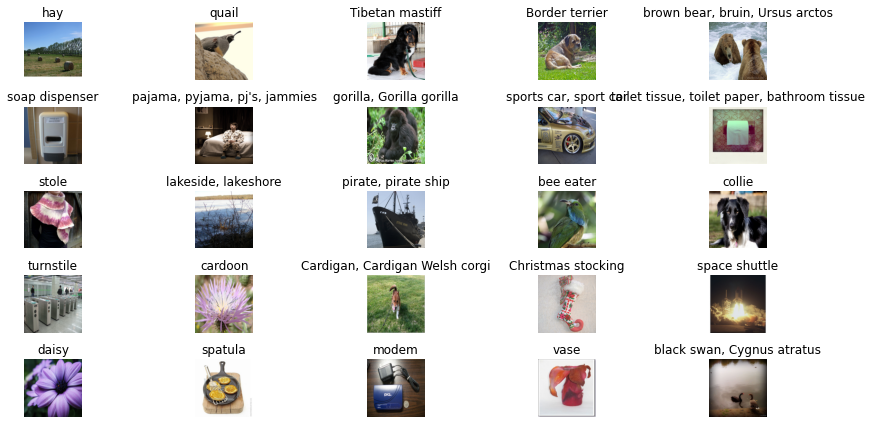

In [0]:
# Display entire ImageNet subset downloaded from cs231n (25 images):
plt.figure(figsize=(12, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_np[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

### Load Pretrained Models

In [0]:
import torchvision.models as models

# Change pretrained model download directory, so it doesn't
# download every time the runtime restarts
os.environ['TORCH_HOME'] = DATA_DIRECTORY + 'models/pretrained'

# Download and load pretrained models
our_models = {}
our_models['resnet'] = models.resnet18(pretrained=True) # other sizes?
our_models['densenet'] = models.densenet161(pretrained=True) # other sizes?
our_models['wide_resnet'] = models.wide_resnet50_2(pretrained=True) # other sizes?
our_models['vgg'] = models.vgg11(pretrained=True) # other sizes?
our_models['alexnet'] = models.alexnet(pretrained=True)
our_models['squeezenet'] = models.squeezenet1_1(pretrained=True)

### k-WTA Activation Function

In [0]:
class kWTA(nn.Module):
    def __init__(self, sr):
        super(kWTA, self).__init__()
        self.sr = sr

    # Modified version of paper's forward implementation
    def forward(self, x):
        # Custom code to work with any array size:
        tmpx = x.view(x.shape[0], -1)
        size = tmpx.shape[1]
        k = int(self.sr * size)
        # Directly taken from paper's implementation:
        topval = tmpx.topk(k, dim=1)[0][:,-1]
        topval = topval.repeat(tmpx.shape[1], 1).permute(1,0).view_as(x)
        comp = (x>=topval).to(x)
        return comp*x

# Our alternate forward implementation v1
# def kWTA(X):
#     X_lin = X.view(X.shape[0], -1)
#     length = X_lin.shape[1]
#     k = int(sr * length)
#     top_inds = X_lin.topk(k, dim=1)[1]
#     # WORK IN PROGRESS

In [0]:
# Replaces ReLU with kWTA activation function in model
def relu_to_kwta(model, sr=0.2):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, kWTA(sr))
        else:
            relu_to_kwta(child, sr)

### Attack: Vanilla Gradient Ascent
Code taken from Fooling Images problem in PS2.

In [0]:
def make_fooling_image(X, target_y, model, max_iter=100, debug=True):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.
    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN
    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """

    model.eval()

    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone()
    X_fooling_var = Variable(X_fooling, requires_grad=True)

    learning_rate = 10 # fixed learning rate
    
    for it in range(max_iter):
    ##############################################################################
    # Generate a fooling image X_fooling that the model will classify as #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled. #
    # When computing an update step, first normalize the gradient: #
    # dX = learning_rate * g / ||g||_2 #
    ##############################################################################
        scores = model(X_fooling_var)[0] # only one image
        target_score = scores[target_y]
        if debug:
            print("Iteration: %d, Target Score: %d" % (it, target_score.data))
        if scores.argmax() == target_y:
            break
        target_score.backward()
        image_grad = X_fooling_var.grad.data
        dX = learning_rate * image_grad / image_grad.norm()
        X_fooling_var.data += dX # gradient *ascent*, so adding not subtracting dX

    X_fooling = X_fooling_var.data

    return X_fooling, it

In [0]:
def vis_fooling_img(X_orig, y_orig, X_fooling, target_y, class_names):
    X_fooling_np = np.array(deprocess(X_fooling.clone()))
    X_np = np.array(deprocess(X_orig.clone()))

    plt.subplot(1, 4, 1)
    plt.imshow(X_np)
    plt.title(class_names[y_orig])
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(X_fooling_np)
    plt.title(class_names[target_y])
    plt.axis('off')

    plt.subplot(1, 4, 3)
    diff = np.array(deprocess(X_fooling - X_orig, should_rescale=False))
    plt.imshow(diff)
    plt.title('Difference')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    diff = np.array(deprocess(10 * (X_fooling - X_orig), should_rescale=False))
    plt.imshow(diff)
    plt.title('Magnified difference (10x)')
    plt.axis('off')

    plt.gcf().set_size_inches(12, 5)
    plt.show()

### Putting it together

In [0]:
def eval_and_attack(model_in, kwta=False, sparsity_ratio=0.2, input_inds=[0], target_inds=[0], debug=False):
    # Print identifying info
    print("model =", type(model_in).__name__)
    if kwta:
        print("kwta with sr =", sparsity_ratio)

    # copying model so we don't have to load them again after modifying
    import copy
    model = copy.deepcopy(model_in)
    # transfer to GPU for CUDA
    model.to(device)
    # put into evaluation mode
    model.eval()
    # Not going to train the model, so don't compute gradients w.r.t. parameters.
    # Using this instead of `with torch.no_grad()` because we still want gradients w.r.t. inputs.
    for param in model.parameters():
        param.requires_grad = False

    # convert ReLU to kWTA if specified so in arguments
    if kwta:
        relu_to_kwta(model, sr=sparsity_ratio)
    
    if debug:
        print(model)

    # predict labels for each image in X using the model
    outputs = model(X.to(device))

    # compare predictions with ground truth
    _, predicted = torch.max(outputs, 1)
    predicted = np.array(predicted.cpu())
    correct = (predicted == y).sum().item()
    print("Accuracy:", correct, "/ 25 =", 100*correct/25, "%")
    # if in debug mode, print prediction vs ground truth for each image
    if debug:
        for i in range(len(y)):
            print("Actual: ", class_names[y[i]].ljust(50), "Predicted: ", class_names[predicted[i]])

    # Adversarial attack loop:
    num_robust = 0 # count how many times model's prediction was still correct after attack
    num_fooled = 0 # count how many time the attack succeeded with the target class
    num_attempts = len(input_inds) * len(target_inds)
    for input_idx in input_inds: # for each input image to attack
        for target_idx in target_inds: # for each target label
            # attempt to make a fooling image with vanilla gradient ascent attack
            X_fooling, num_iter = make_fooling_image(
                    X[input_idx:input_idx+1].to(device),
                    target_idx, model, max_iter=20, debug=debug)
            # evaluate fooling image with the model
            scores = model(X_fooling)
            is_fooled = scores.data.max(1)[1][0] == target_idx
            is_correct = scores.data.max(1)[1][0] == y[input_idx]
            if debug:
                if is_fooled:
                    print('Fooled model, iterations =', num_iter)
                else:
                    print('Failed to fool model!')
                X_fooling = X_fooling.cpu()
                # Visualize fooling image and original image differences
                vis_fooling_img(X[input_idx:input_idx+1], y[input_idx], X_fooling, target_idx, class_names)
            if is_fooled:
                num_fooled += 1
            if is_correct:
                num_robust += 1
    
    print("Attacks Succeeded:", num_fooled, "/", num_attempts, "=", 100*num_fooled/num_attempts, "%")
    print("Robustness Accuracy: ", num_robust, "/", num_attempts, "=", 100*num_robust/num_attempts, "%")

In [0]:
eval_and_attack(our_models['vgg'], kwta=True, sparsity_ratio=0.1, input_inds=range(25), target_inds=[0], debug=False)

model = VGG
kwta with sr = 0.1
Accuracy: 10 / 25 = 40.0 %
Attacks Succeeded: 18 / 25 = 72.0 %
Robustness Accuracy:  0 / 25 = 0.0 %
